In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import model_selection
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, balanced_accuracy_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('once')


# 1 Data formatting

In [33]:
metadata = pd.read_csv('Data/Metadata/102GL_meta_clim.csv')
metadata = metadata[~np.isnan(metadata['sba [cells g-1]'])]

data = pd.read_csv('data/16S/NOMIS_16S_table_0122_filtered.csv')
tax_data = pd.read_csv('data/16S/NOMIS_16S_taxonomy_0122_filtered.csv')

metadata = metadata[metadata.patch.isin(data.columns)]
data.index = data.Feature_ID
data = data[metadata.patch]

print(data.shape)
print(tax_data.shape)
print(metadata.shape)

(3346, 512)
(3346, 10)
(512, 67)


# 2 Feature importance

In [34]:
imp_data = pd.read_csv('Data/importance_features_suitability.csv')
imp_data.head()

,Feature,ASV,Transformation,Balanced accuracy
0,water_temp [°C],2644fcb78133eabecec33bf52d9420af,raw,0.500000
1,water_temp [°C],2644fcb78133eabecec33bf52d9420af,log,0.454495
2,water_temp [°C],e85f3f8254c50d0e9c37c737c7ccd039,raw,0.500000
3,water_temp [°C],e85f3f8254c50d0e9c37c737c7ccd039,log,0.581461
4,water_temp [°C],896139adf53d1d8d4954de045f4d0cf2,raw,0.500000


In [35]:
for feat in list(set(imp_data.Feature)):
    bal_acc_raw = imp_data.loc[imp_data.Transformation == 'raw', 'Balanced accuracy'].mean()
    bal_acc_log = imp_data.loc[imp_data.Transformation == 'log', 'Balanced accuracy'].mean()
    if bal_acc_raw > bal_acc_log:
        imp_data.drop(imp_data.loc[imp_data.Transformation == 'log', 'Balanced accuracy'].index, inplace=True)
    else:
        imp_data.drop(imp_data.loc[imp_data.Transformation == 'raw', 'Balanced accuracy'].index, inplace=True)

/Users/mabourqu/opt/anaconda3/envs/SDMs/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/Users/mabourqu/opt/anaconda3/envs/SDMs/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='Balanced accuracy', ylabel='Feature'>

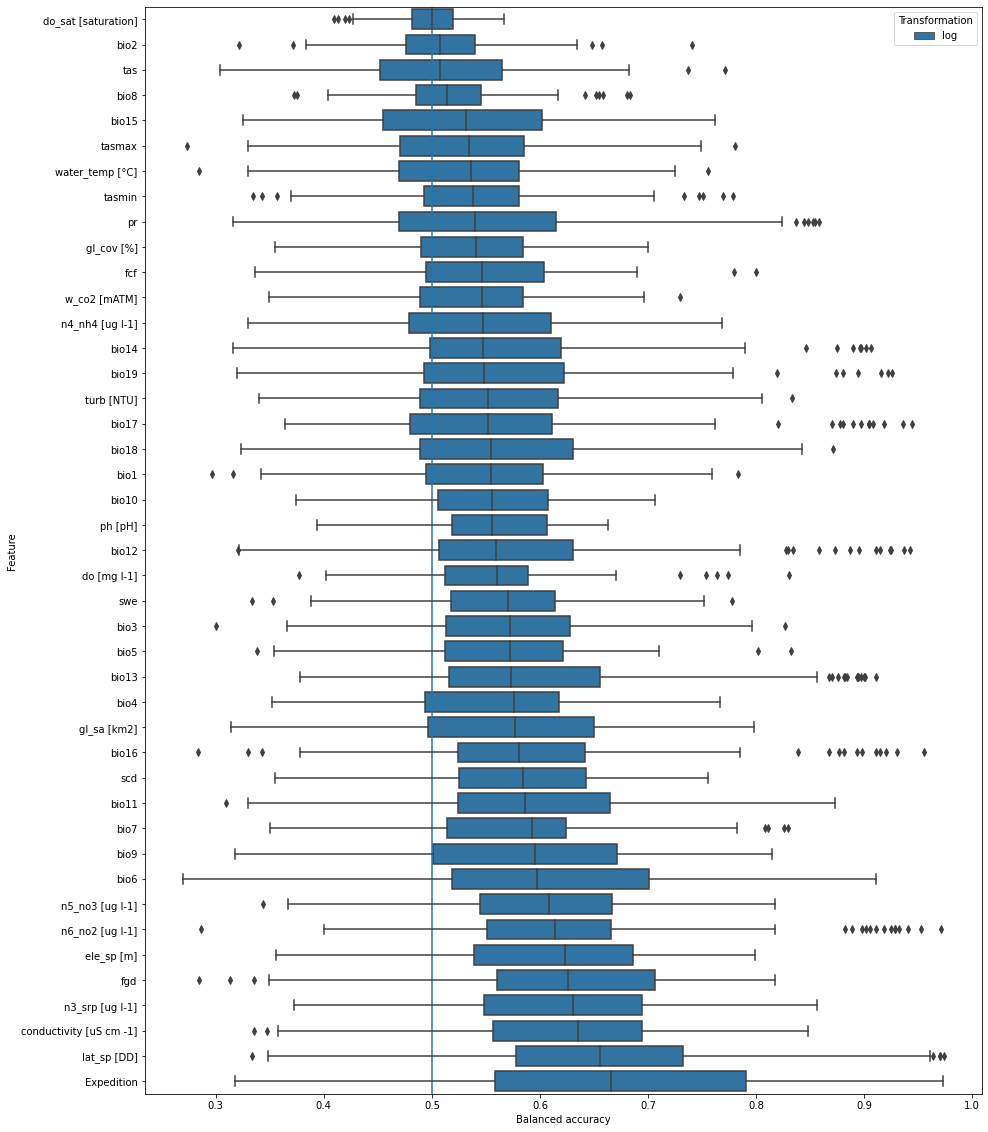

In [65]:
avgs = imp_data.groupby(['Feature', 'Transformation'])['Balanced accuracy'].median().reset_index().sort_values('Balanced accuracy')
plt.figure(figsize=(15,20))
plt.axvline(x=0.5)
sns.boxplot(data=imp_data, x='Balanced accuracy', y='Feature', hue='Transformation', order=avgs['Feature'])

In [49]:
features = ['water_temp [°C]', 'ph [pH]', 'do [mg l-1]',
       'do_sat [saturation]', 'w_co2 [mATM]', 'conductivity [uS cm -1]',
       'turb [NTU]', 'lat_sp [DD]', 'ele_sp [m]', 'gl_sa [km2]', 'gl_cov [%]', 
       'n3_srp [ug l-1]', 'n4_nh4 [ug l-1]',
       'n5_no3 [ug l-1]', 'n6_no2 [ug l-1]', 'bio10', 'bio11', 'bio12',
       'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'bio1',
       'bio2', 'bio3', 'bio4', 'bio5', 'bio6', 'bio7', 'bio8', 'bio9', 'fcf',
       'fgd', 'scd', 'swe', 'pr', 'tas', 'tasmin', 'tasmax']
X = metadata[features]

def LogTrans(x):
    min_val = x.min()
    return(np.log(x + np.abs(min_val) + 1))

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=features)
X = X.apply(lambda x:LogTrans(x))
        
exps = pd.get_dummies(metadata.Expedition, prefix='exp')
exps = LogTrans(exps)
X = pd.concat([X, exps], axis=1)
print(X.head())

   water_temp [°C]   ph [pH]  do [mg l-1]  do_sat [saturation]  w_co2 [mATM]  \
0         0.719557  1.435223     1.657508             1.822692      1.489488   
1         0.719557  1.435223     1.657508             1.822692      1.489488   
2         0.719557  1.435223     1.657508             1.822692      1.489488   
3         0.859001  1.414969     1.669696             1.839831      1.559271   
4         0.859001  1.414969     1.669696             1.839831      1.559271   

   conductivity [uS cm -1]  turb [NTU]  lat_sp [DD]  ele_sp [m]  gl_sa [km2]  \
0                 0.740937    0.882681     0.032193    0.184213     1.557424   
1                 0.740937    0.882681     0.032193    0.184213     1.557424   
2                 0.740937    0.882681     0.032193    0.184213     1.557424   
3                 0.642445    0.856498     0.032741    0.018073     1.557424   
4                 0.642445    0.856498     0.032741    0.018073     1.557424   

   ...        pr      tas    tasmin   

<AxesSubplot:>

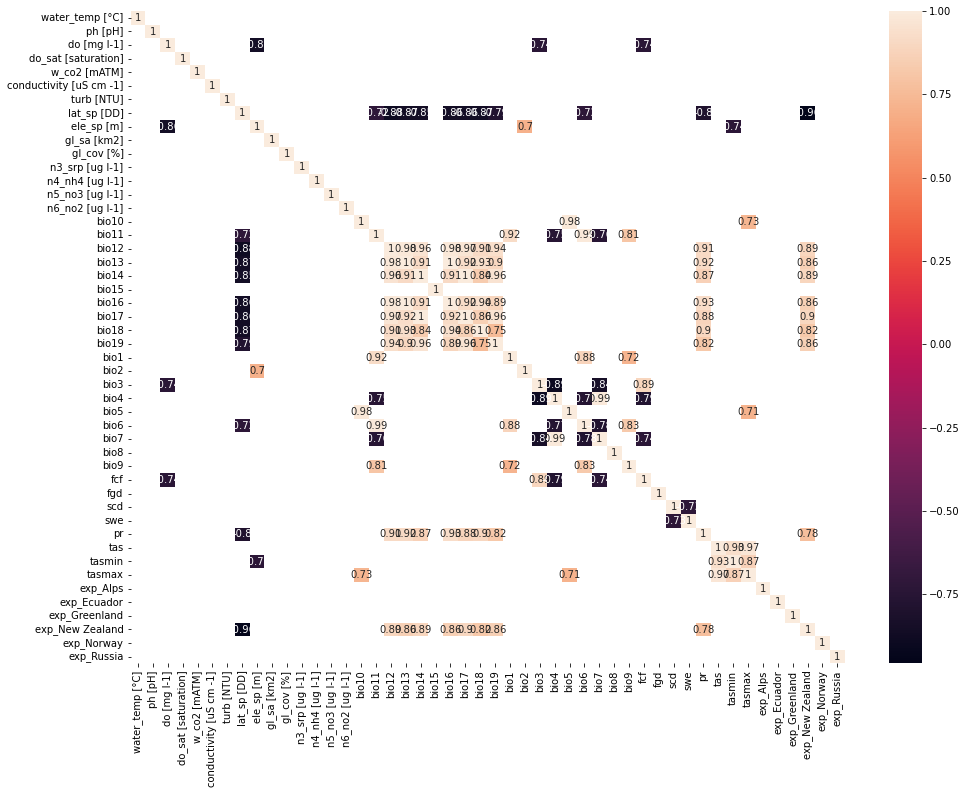

In [50]:
corrs = X.corr()
corrs[(corrs < 0.7) & (corrs >= 0)] = np.nan
corrs[(corrs > -0.7) & (corrs <= 0)] = np.nan 
(fig, ax) = plt.subplots(figsize=(16, 12))
sns.heatmap(corrs, annot=True)

<AxesSubplot:>

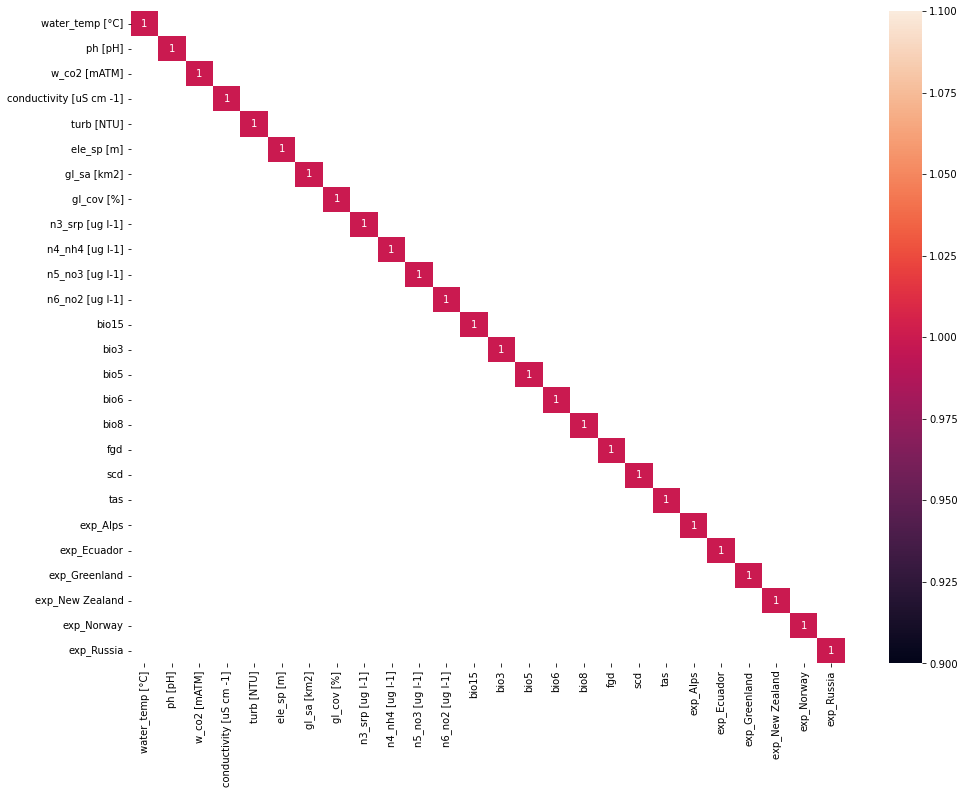

In [69]:
corrs = X[['water_temp [°C]', 'ph [pH]', 'w_co2 [mATM]', 'conductivity [uS cm -1]',
           'turb [NTU]', 'ele_sp [m]', 'gl_sa [km2]', 'gl_cov [%]', 
           'n3_srp [ug l-1]', 'n4_nh4 [ug l-1]', 'n5_no3 [ug l-1]', 'n6_no2 [ug l-1]',
           'bio15', 'bio3', 'bio5', 'bio6','bio8', 'fgd', 'scd', 'tas', 
           'exp_Alps', 'exp_Ecuador', 'exp_Greenland', 'exp_New Zealand', 'exp_Norway', 'exp_Russia']].corr()
corrs[(corrs < 0.7) & (corrs >= 0)] = np.nan
corrs[(corrs > -0.7) & (corrs <= 0)] = np.nan 
(fig, ax) = plt.subplots(figsize=(16, 12))
sns.heatmap(corrs, annot=True)

In [111]:
features = ['water_temp [°C]', 'ph [pH]', 'w_co2 [mATM]', 'conductivity [uS cm -1]',
           'turb [NTU]', 'ele_sp [m]', 'gl_sa [km2]', 'gl_cov [%]', 
           'n3_srp [ug l-1]', 'n4_nh4 [ug l-1]', 'n5_no3 [ug l-1]', 'n6_no2 [ug l-1]',
           'bio15', 'bio3', 'bio5', 'bio6','bio8', 'fgd', 'scd', 'tas']
X = metadata[features]
X.index = metadata.location
X = X.groupby('location').mean()

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=features)
X = X.apply(lambda x:LogTrans(x))
        
exps = pd.get_dummies(metadata.Expedition, prefix='exp')
exps.index = metadata.location
exps = exps.groupby('location').mean()
X.index = exps.index
X = pd.concat([X, exps], axis=1)

print(X.head())

          water_temp [°C]   ph [pH]  w_co2 [mATM]  conductivity [uS cm -1]  \
location                                                                     
GL100_DN         0.677683  1.424559      1.048250                 1.648449   
GL100_UP         0.424427  1.420565      1.081986                 1.683320   
GL101_DN         1.217643  1.367133      1.041115                 1.159397   
GL101_UP         0.162321  1.362902      1.117798                 1.538269   
GL102_DN         1.000014  1.408485      1.192770                 1.061598   

          turb [NTU]  ele_sp [m]  gl_sa [km2]  gl_cov [%]  n3_srp [ug l-1]  \
location                                                                     
GL100_DN    0.057591    0.958196     0.122021    0.663463         0.144918   
GL100_UP    0.040443    0.978555     0.120152    0.710818         0.151994   
GL101_DN    0.042243    0.886295     0.122955    0.319618         0.151994   
GL101_UP    0.052976    1.019515     0.082979    0.777893      

# 2 ...

In [ ]:
suit_features = ['water_temp [°C]', 'ph [pH]', 'w_co2 [mATM]', 'conductivity [uS cm -1]',
           'turb [NTU]', 'ele_sp [m]', 'gl_sa [km2]', 'gl_cov [%]', 
           'n3_srp [ug l-1]', 'n4_nh4 [ug l-1]', 'n5_no3 [ug l-1]', 'n6_no2 [ug l-1]',
           'bio15', 'bio3', 'bio5', 'bio6','bio8', 'fgd', 'scd', 'tas', 
           'exp_Alps','exp_Ecuador','exp_Greenland','exp_New Zealand','exp_Norway','exp_Russia']

def LogTrans(x):
    min_val = x.min()
    return(np.log(x + np.abs(min_val) + 1))

LogTransformer = FunctionTransformer(LogTrans)

def SuitabilityModel(ASV, data, metadata, X):
    X = X.groupby('location').mean()
    metadata['location'] = metadata.patch.apply(lambda x: '_'.join(x.split('_')[0:2]))
    metadata_num = metadata.groupby('location').mean()    
    metadata_num['Presence'] = metadata_num.index.map(lambda x: int(data.loc[ASV, data.columns.str.startswith(x)].mean(axis=0) > 0))
    y = metadata_num['Presence']

    print(X.shape)
    print(y.shape)
    
    rkf = model_selection.RepeatedStratifiedKFold(n_splits=5,n_repeats=5)
    clf = SVC(class_weight='balanced')
    model = make_pipeline(StandardScaler(), LogTransformer, clf)
    pred = model_selection.cross_validate(model, X, y, cv=rkf, 
                                          scoring='balanced_accuracy',
                                          error_score='raise',
                                          n_jobs=8)
    print(pred['test_score'].mean())

SuitabilityModel('0a6a60c3cb3fde7ca0a4207d889862f3', data, metadata, X)

(180, 26)
(180,)


In [243]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we

# 4 Species distribution models

In [24]:
data = data.sort_index(axis=1)
metadata = metadata.sort_values(by = 'patch')
print(metadata.patch == data.columns)

le = preprocessing.LabelEncoder()
le.fit(metadata['Expedition'])
metadata['Expedition'] = le.transform(metadata['Expedition'])

features = ['gl_cov [%]', 'ph [pH]', 'water_temp [°C]','Expedition', 'tasmin', 'pr', 'bio8', 'bio9', 'bio5',
            'n3_srp [ug l-1]', 'n4_nh4 [ug l-1]', 'n5_no3 [ug l-1]', 'conductivity [uS cm -1]', 'turb [NTU]', 
            'chla [ug g-1]','ag [nmol g-1 h-1]', 'bg [nmol g-1 h-1]', 'lap [nmol g-1 h-1]', 
            'respiration [mg 02 g-1 h-1]']

X = metadata[features]

print(metadata.shape)
print(X.shape)
print(X.columns)

sdm_out = pd.DataFrame(columns = ['Species', 'R2', 'Samples', 'Prevalence'] + X.columns.tolist())

#for ASV in data.sample(40).index:
for ASV in ['b7b162821b88054ff8ff4cc3505ce036','dae457dce2089ce83fd9a96ce128ec7a',
            '6b3aee6a4c27acc73ccae91dd07382b5','7258fea50395ec2b3aff4e55bddd5aea',
            'b5289da01e3ddf113f34092dc6518955','f54dd1b0aa8d377ea715edc62be86e28',
            '5316e0e4cde61d09d1e992d564f75386','ddc0ef324f2c6611f39ff3ff8586242d',
            '42a83ed857d453058f31ea7343f21c15']:
    y = np.log(data.loc[ASV].values.ravel()+1)
    preval = np.mean(y > 0)
    print('------------------')
    print(ASV)
    
    kf = model_selection.RepeatedKFold(n_splits = 5, n_repeats = 10)
    clf = HistGradientBoostingRegressor(categorical_features = (X.columns == 'Expedition'), 
                                        random_state = 0,
                                        learning_rate = 0.05,
                                        scoring = 'r2',
                                        max_bins = 100,
                                        max_iter = 1000)
    #grid = model_selection.GridSearchCV(clf, parameters, cv=kf, scoring='r2',refit=True).fit(X,y)
    cv_res = model_selection.cross_validate(clf, X, y, cv=kf, scoring='r2', return_estimator=True)
    r2_score = cv_res['test_score'].mean()
    print(f'5-fold Cross Validation r2: {r2_score}')
    
    imp_df = np.empty((0,X.shape[1]))
    for idx, estimator in enumerate(cv_res['estimator']):
        imp_res = permutation_importance(estimator, X, y, n_repeats=3, random_state=0, n_jobs=8)
        imp_df = np.vstack([imp_df, imp_res.importances_mean])
        
    sdm_out.loc[ASV] = [ASV, r2_score, X.index[y==1], preval] + np.mean(imp_df, axis=0).tolist() 

sdm_out.head(20)

591    True
592    True
593    True
588    True
589    True
       ... 
46     True
47     True
42     True
43     True
44     True
Length: 512, dtype: bool
(512, 67)
(512, 19)
Index(['gl_cov [%]', 'ph [pH]', 'water_temp [°C]', 'Expedition', 'tasmin',
       'pr', 'bio8', 'bio9', 'bio5', 'n3_srp [ug l-1]', 'n4_nh4 [ug l-1]',
       'n5_no3 [ug l-1]', 'conductivity [uS cm -1]', 'turb [NTU]',
       'chla [ug g-1]', 'ag [nmol g-1 h-1]', 'bg [nmol g-1 h-1]',
       'lap [nmol g-1 h-1]', 'respiration [mg 02 g-1 h-1]'],
      dtype='object')
------------------
b7b162821b88054ff8ff4cc3505ce036
5-fold Cross Validation r2: 0.11995327156948747
------------------
dae457dce2089ce83fd9a96ce128ec7a
5-fold Cross Validation r2: 0.23799364580729254


KeyboardInterrupt: 

0.5326831999583753
7
0


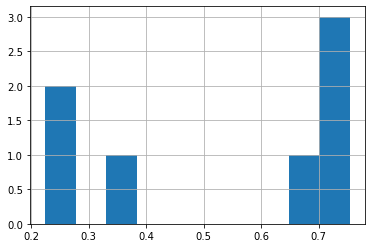

In [17]:
import matplotlib.pyplot as plt

print(sdm_out.R2.mean())
sdm_out['R2'].hist()
print((sdm_out['R2'] >= 0.2).sum())
print((sdm_out['R2'] < 0.2).sum())

<AxesSubplot:>

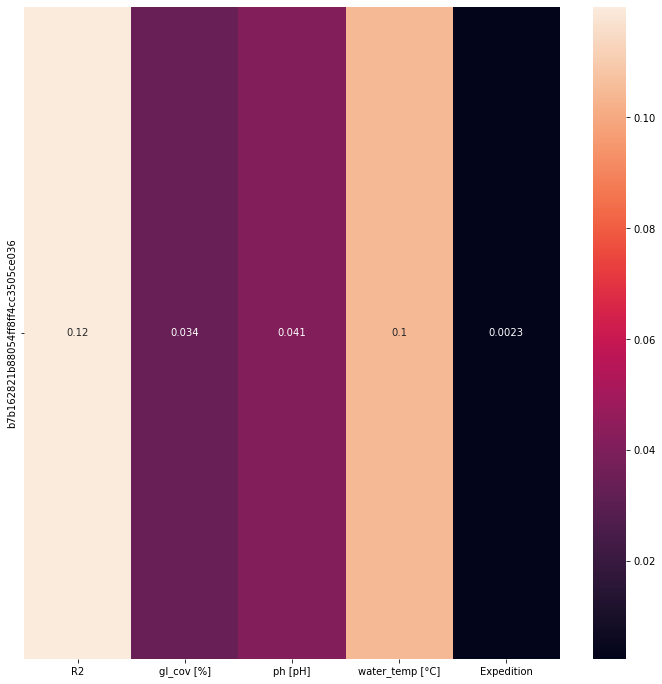

In [25]:
import seaborn as sns

(fig, ax) = plt.subplots(figsize=(12, 12))
sns.heatmap(sdm_out[['R2', 'gl_cov [%]', 'ph [pH]', 'water_temp [°C]','Expedition']], annot=True)

<AxesSubplot:>

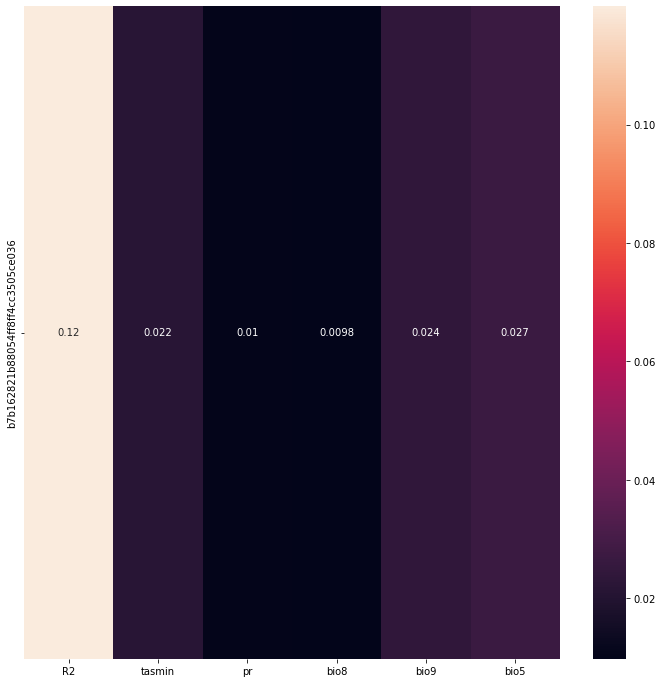

In [26]:
(fig, ax) = plt.subplots(figsize=(12, 12))
sns.heatmap(sdm_out[['R2', 'tasmin', 'pr', 'bio8', 'bio9', 'bio5']], annot=True)

<AxesSubplot:>

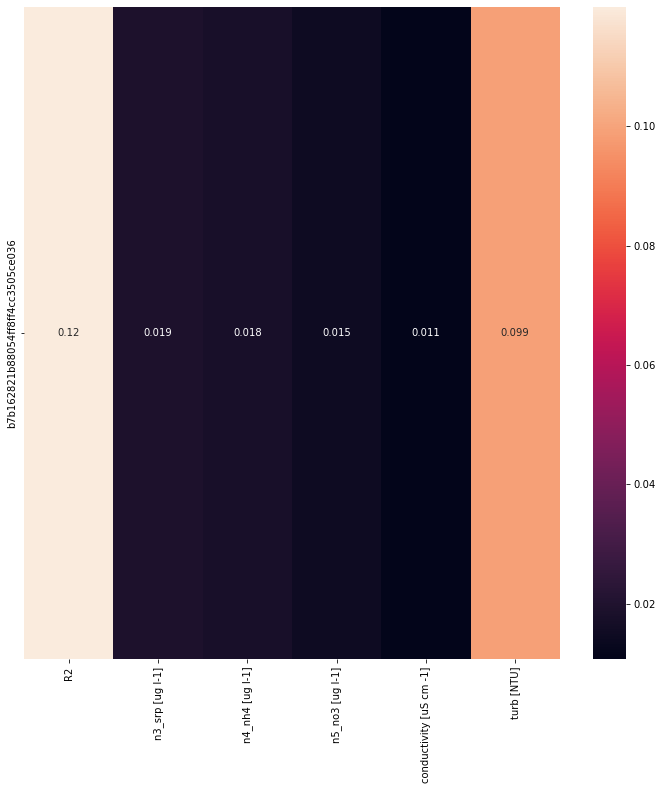

In [27]:
(fig, ax) = plt.subplots(figsize=(12, 12))
sns.heatmap(sdm_out[['R2', 'n3_srp [ug l-1]', 'n4_nh4 [ug l-1]', 'n5_no3 [ug l-1]', 'conductivity [uS cm -1]', 'turb [NTU]']], annot=True)


<AxesSubplot:>

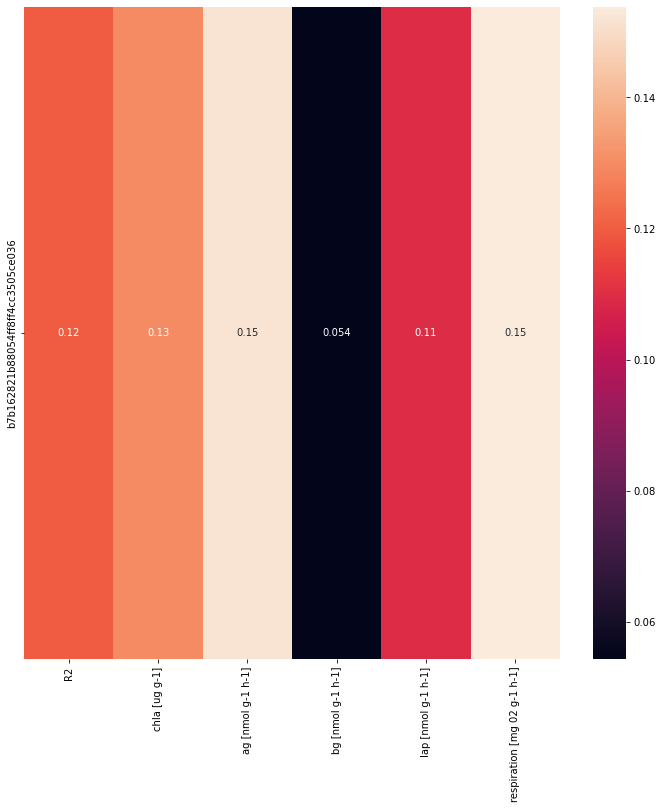

In [28]:
(fig, ax) = plt.subplots(figsize=(12, 12))
sns.heatmap(sdm_out[['R2','chla [ug g-1]','ag [nmol g-1 h-1]', 'bg [nmol g-1 h-1]', 'lap [nmol g-1 h-1]', 
                     'respiration [mg 02 g-1 h-1]']], annot=True)